# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

In [1]:
##RUN ME##
!conda install scipy --yes
!pip install --upgrade sklearn

Fetching package metadata: ....
Solving package specifications: .................
Package plan for installation in environment /root/miniconda/envs/rep_py2:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libgfortran-3.0.0          |                1         281 KB
    mkl-11.3.3                 |                0       122.1 MB
    numpy-1.11.0               |           py27_1         6.2 MB
    pip-8.1.2                  |           py27_0         1.5 MB
    scipy-0.17.1               |      np111py27_0        30.1 MB
    ------------------------------------------------------------
                                           Total:       160.2 MB

The following packages will be UPDATED:

    libgfortran: 1.0-0              --> 3.0.0-1           
    mkl:         11.3.1-0           --> 11.3.3-0          
    numpy:       1.10.4-py27_1      --> 1.11.0-py27_1     
    pip:         8.1.1-p

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N - 1
* Use numpy or python
* An array of numbers 0 to N -1 is numpy.arange(N)

In [7]:
import numpy as np
def sum_squares(N):
    return (np.array(range(N))**2).sum()

In [14]:
%%time
sum_squares(10 ** 8)

KeyboardInterrupt: 

In [15]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
T.arange(10)

ARange{dtype='int64'}.0

# theano teaser

Doing the very same thing

In [9]:
import theano
import theano.tensor as T

In [10]:
# I gonna be function parameter
N = T.scalar("a dimension", dtype='int32')

# I am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N) ** 2).sum()

# Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs=[N], outputs=result)

In [13]:
%%time
sum_function(10 ** 8)

CPU times: user 311 ms, sys: 235 ms, total: 545 ms
Wall time: 548 ms


array(662921401752298880)

# How does it work?

1. You define inputs f your future function;
2. You write a recipe for some transformation of inputs;
3. You compile it;


* You have just got a function! (you define a function as symbolic computation graph.)


* There are two main kinds of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean, np.arange -> T.arange, np.cumsum -> T.cumsum
   * np.arange(10).mean() -> T.arange(10).mean()
   * and so on.
   * builtin operations also work that way
   * Sometimes the functions have different names or locations (e.g. T.extra_ops)
 
Still confused? We gonna fix that.

In [17]:
# Inputs

example_input_integer = T.scalar("scalar input", dtype='float32')

example_input_tensor = T.tensor4("four dimensional tensor input") # dtype=theano.config.floatX by default
# Don't worry, you'll not need 4d! (so far)

# vector of integers:
input_vector = T.vector("integers_vector", dtype='int32')

In [18]:
# Transformations

# transofrmation: elementwise multiplication
double_the_vector = input_vector * 2

# elementwise cosine
elementwise_cosine = T.cos(input_vector)

# difference between squared vector and vector itself
vector_squares = input_vector ** 2 - input_vector

In [21]:
# Practice time:
# create two float32 vectors
my_vector =  T.vector('myvec1',dtype='float32')
my_vector2 =  T.vector('myvec2',dtype='float32')

In [22]:
# Write a transformation (recipe):
# (my_vector)*(my_vector2) / (sin(my_vector) + 1)
my_transformation = my_vector*my_vector2 / (T.sin(my_vector) + 1)

In [23]:
print my_transformation
# it's okay this isn't a number. This is an abstract expression (or transformation of input variables)

Elemwise{true_div,no_inplace}.0


# Compiling

* So far we used "symbolic" variables and symbolic expressions 
    * Defining the recipe for computation, but not computing anything
* To use the "recipe" (symbolic expression), one should **compile it**. 

We started with defining *mathematical function*, process of compiling turns this into *programmer's function* (which is able to efficiently calculate outputs given the input values)

In [24]:
inputs = [my_vector,my_vector2]
outputs = [my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs, outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
)

In [27]:
# using function with lists:
print "using python lists:"
print my_function([1, 2, 3], [4, 5, 6])
print "\n"

# Or using numpy arrays (should be preferred):
# BTW, that 'float' dtype is casted to second parameter dtype which is float32
print "using numpy arrays:"
print my_function(np.arange(10),
                  np.linspace(5, 6, 10, dtype='float'))

using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]


using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [ ]:
# a dictionary of inputs
my_function_inputs = {
    my_vector: [1, 2, 3],
    my_vector2: [4, 5, 6]
}

# evaluate my_transformation
# has to match with compiled function output
print my_transformation.eval(my_function_inputs)

# can compute transformations on the fly
print "add 2 vectors", (my_vector + my_vector2).eval(my_function_inputs)

# WARNING! if your transformation only depends on some inputs,
# do not provide the rest of them
print "vector's shape:", my_vector.shape.eval({
    my_vector: [1, 2, 3]
})

* It's generally a good idea to stay on a smaller scale when debugging since code runs slower without optimization. Subsampling (X[:10]) would be a good start.
* If you strongly require large scale computations, it may be faster to just compile the function. 

# Your turn

In [33]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

Y = T.vector(dtype='float32')
Y_pred = T.vector(dtype='float32')

mse = ((Y- Y_pred)**2).mean()

compute_mse = theano.function([Y,Y_pred],mse,allow_input_downcast=True)

In [34]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10 ** 3]:

    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]

    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print 'Wrong result:'
                print 'mse(%s,%s)' % (el, el_2)
                print "should be: %f, but your function returned %f" % (true_mse, my_mse)
                raise ValueError("Something is wrong!")

print "ok, tests passed"

ok, tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [36]:
# creating shared variable
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [39]:
# evaluating shared variable (outside symbolic graph)
print "initial value", shared_vector_1.get_value()

# within symbolic graph you use them just as any other input or transformation, not "get value" needed

initial value [ 0.  1.  2.  3.  4.]


In [38]:
# setting new value
shared_vector_1.set_value(np.arange(5))

# getting that new value
print "new value", shared_vector_1.get_value()

# Note that the vector changed shape
# This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

new value [ 0.  1.  2.  3.  4.]


# Your turn

In [40]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
# Compile as a function of input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar*shared_vector_1

shared_times_n = theano.function([input_scalar], scalar_times_shared)

In [41]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)", shared_times_n(5)

print "shared_times_n(-0.5)", shared_times_n(-0.5)

shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [42]:
# Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1, 0, 1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)", shared_times_n(5)

print "shared_times_n(-0.5)", shared_times_n(-0.5)

shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [44]:
my_scalar = T.scalar(name='input', dtype='float64')

scalar_squared = T.sum(my_scalar ** 2)

# a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative)

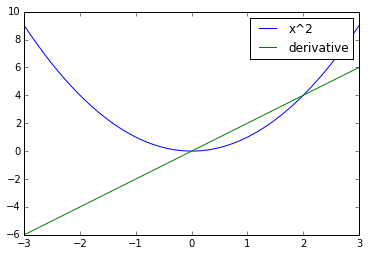

In [45]:
x = np.linspace(-3, 3)
x_squared = map(fun, x)
x_squared_der = map(grad, x)

plt.plot(x, x_squared, label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()


# Why `T.grad` rocks

In [120]:
def super_fun(x):
    my_vector = my_scalar = T.repeat(x,5)
    wps = ((my_vector + my_scalar)**(1 + T.var(my_vector)) + \
                  1. / T.arcsinh(my_scalar)).mean() / (my_scalar**2 + 1) + \
                  0.01 * T.sin(2 * my_scalar**1.5) * (T.sum(my_vector) * my_scalar**2) \
                  * T.exp((my_scalar - 4)**2) / (1 + T.exp((my_scalar - 4)**2)) * \
                 (1 - (T.exp(-(my_scalar-4)**2)) / (1 + T.exp(-(my_scalar-4)**2)))**2
    return wps.mean()

In [47]:
%%time
my_vector = T.vector('float64')

# Compute the gradient of the next function over my_scalar and my_vector
# Note: trying to understand the meaning of function below may result in brain damage

weird_function = ((my_vector + my_scalar)**(1 + T.var(my_vector)) + \
                  1. / T.arcsinh(my_scalar)).mean() / (my_scalar**2 + 1) + \
                  0.01 * T.sin(2 * my_scalar**1.5) * (T.sum(my_vector) * my_scalar**2) \
                  * T.exp((my_scalar - 4)**2) / (1 + T.exp((my_scalar - 4)**2)) * \
                 (1 - (T.exp(-(my_scalar-4)**2)) / (1 + T.exp(-(my_scalar-4)**2)))**2


der_by_scalar = T.grad(weird_function,my_scalar)
der_by_vector = T.grad(weird_function,my_vector)


compute_weird_function = theano.function([my_scalar,my_vector], weird_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector], der_by_scalar)

# Optional exercise on calculus: compute derivatives

CPU times: user 1.04 s, sys: 3.85 ms, total: 1.05 s
Wall time: 1.05 s


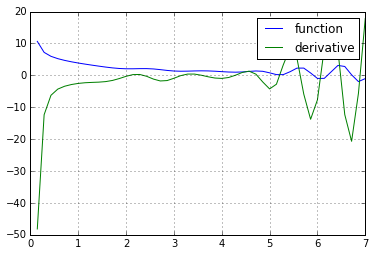

In [48]:
# Plotting your derivative
vector_0 = [1, 2, 3]

scalar_space = np.linspace(0, 7)

y = [compute_weird_function(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y, label='function')
y_der_by_scalar = [compute_der_by_scalar(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend()

# Last element: updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [51]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared]  # return vector times scalar

my_updates = {
    shared_vector_1: scalar_times_shared  # and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)


In [53]:
#shared_vector_1.set_value(np.arange(5))

# initial shared_vector_1
print "initial shared value:", shared_vector_1.get_value()

# evaluating the function (shared_vector_1 will be changed)
print "compute_and_save(2) returns", compute_and_save(2)

# evaluate new shared_vector_1
print "new shared value:", shared_vector_1.get_value()


initial shared value: [ 0.  2.  4.  6.  8.]
compute_and_save(2) returns [array([  0.,   4.,   8.,  12.,  16.])]
new shared value: [  0.   4.   8.  12.  16.]


# Logistic regression example

Implement the regular logistic regression training algorithm

Tips:
* Weights are represented as a shared variable
* X and y are potential inputs
* Compile 2 functions:
    * train_function(X, y) - returns error and computes new values of weights __(through updates)__
    * predict_fun(X) - just computes probabilities ("y") given data
    
    
    let T be true Y , P be probability predicted by logregression
    
    
    $$ Loss = T*log(P) + (1-T)*log(1-P) $$
 
We shall train on a two-class MNIST dataset
    * please note that target y are {0,1} and not {-1,1} as in some formulae
    
let T be true Y , P be probability predicted by logregression
    
    
$$ Loss = T*log(P) + (1-T)*log(1-P) $$

In [64]:
from sklearn.datasets import load_digits

mnist = load_digits(2)

X, y = mnist.data, mnist.target

print "y [shape - %s]:" % (str(y.shape)), y[:10]
print "X [shape - %s]:" % (str(X.shape))
print X[:3]
print y[:10]


y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [56]:
# inputs and shareds
shared_weights = theano.shared(np.zeros(64))
input_X = T.matrix('float64')
input_y = T.vector('float64')

In [67]:
predicted_y = 1/(1+np.e**(-input_X.dot(shared_weights)))
loss = input_y*T.log(predicted_y) + (1-input_y)*T.log(1-predicted_y)
loss = loss.mean()

grad = T.grad(loss,shared_weights)


updates = {
    shared_weights: shared_weights  -0.01 * grad
}

In [68]:
train_function = theano.function([input_X,input_y],loss, updates=updates)
predict_function = theano.function([input_X],predicted_y)

In [69]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


loss at iter 0:-0.6931
train auc: 0.0
test auc: 0.0
loss at iter 1:-2.3369
train auc: 0.0
test auc: 0.0
loss at iter 2:-6.2448
train auc: 0.0
test auc: 0.0
loss at iter 3:-10.6441
train auc: 0.0
test auc: 0.0
loss at iter 4:-15.0669
train auc: 0.0
test auc: 0.0
resulting weights:


<matplotlib.colorbar.Colorbar instance at 0x7fde99789998>

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


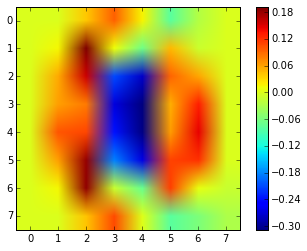

In [70]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print "loss at iter %i:%.4f" % (i, loss_i)
    print "train auc:", roc_auc_score(y_train, predict_function(X_train))
    print "test auc:", roc_auc_score(y_test, predict_function(X_test))

print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8, -1))
plt.colorbar()


# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano (unlike e.g. Keras)

No longer shall we bother ourselves with boring MNIST.

Instead, gonna take... NotMNIST!

* images are 28x28 like original MNIST
* 10 different letters
* 0.5*10^6 samples total

In [76]:
from notmnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print X_train.shape, y_train.shape


using stored data.npz
(423291, 1, 28, 28) (423291,)


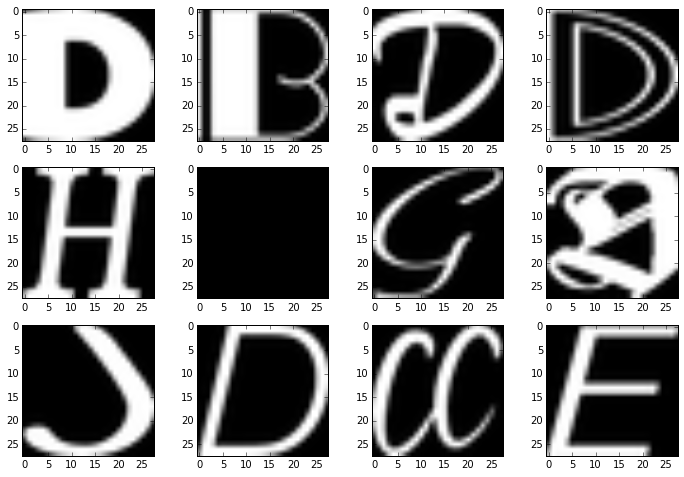

In [77]:
plt.figure(figsize=[12, 8])
for i, x in enumerate(X_train[:12]):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x[0].reshape(28,28), cmap='gray')
plt.show()


In [78]:
import lasagne

input_X = T.tensor4("X")

# input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None, 1, 28, 28]

target_y = T.vector("target Y integer", dtype='int32')


Defining network architecture

In [124]:
# Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)

# fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)

conv0 = lasagne.layers.Conv2DLayer(input_layer, 20,[5,5],name='conv0')
pool0 = lasagne.layers.MaxPool2DLayer(conv0, [5,5],name='pool0')

drop0 = lasagne.layers.DropoutLayer(pool0, p=0.1)

dense_1 = lasagne.layers.DenseLayer(drop0, num_units=50,
                                    nonlinearity=super_fun,
                                    name="hidden_dense_layer")

# fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
# We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1, num_units=10,
                                         nonlinearity=lasagne.nonlinearities.softmax,
                                         name='output')


In [125]:
# network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)


In [126]:
# All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)
print all_weights


[conv0.W, conv0.b, hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### Now you can simply

* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge!

Instead, we shall use `Lasagne` builtins (Lasagne is has lots of noce helpers over `theano`)

In [114]:
reg_l2 = lasagne.regularization.regularize_network_params(dense_output,
                                                         lasagne.regularization.l2)

reg_l1 = lasagne.regularization.regularize_network_params(dense_output,
                                                         lasagne.regularization.l1)

Elemwise{add,no_inplace}.0

In [117]:
# Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

loss += reg_l1+reg_l2
# prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

# This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adamax(loss, all_weights, learning_rate=0.01)


In [103]:
updates_sgd

OrderedDict([(<TensorType(float64, 4D)>, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, 4D)>, Elemwise{maximum,no_inplace}.0),
             (conv0.W, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{maximum,no_inplace}.0),
             (conv0.b, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{maximum,no_inplace}.0),
             (hidden_dense_layer.W, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{maximum,no_inplace}.0),
             (hidden_dense_layer.b, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{maximum,no_inplace}.0),
             (

In [104]:
# function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

# function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use *stochastic* GD
* So let's implement a function that splits the training sample into minibatches

In [105]:
# An auxilary function that returns mini-batches for neural network training

# What do need to implement
# 1) Shuffle data
#    - Gotta shuffle X and y the same way (not to break the correspondence between X_i and y_i)
# 3) Split data into minibatches of batch_size
#    - If data size is not a multiple of a batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
#    - (image batch, labels for that batch)



def iterate_minibatches(inputs, targets, batchsize):
    shuffle = True
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]       
#
#
#
#
#
#
#
#
# Feel lost? Go search for a similar function at
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

# Training loop

In [106]:
# training loop
import time

num_epochs = 100
minibatches_per_epoch = 50
batch_size = 100

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for i, batch in enumerate(iterate_minibatches(X_train, y_train, batch_size)):
        if i > minibatches_per_epoch: break
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for i, batch in enumerate(iterate_minibatches(X_val, y_val, batch_size)):
        if i > minibatches_per_epoch: break
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))


Epoch 1 of 100 took 2.316s
  training loss (in-iteration):		1.095256
  train accuracy:		69.33 %
  validation accuracy:		69.96 %
Epoch 2 of 100 took 2.033s
  training loss (in-iteration):		1.037289
  train accuracy:		69.12 %
  validation accuracy:		68.02 %
Epoch 3 of 100 took 2.165s
  training loss (in-iteration):		0.948793
  train accuracy:		71.59 %
  validation accuracy:		69.92 %
Epoch 4 of 100 took 2.085s
  training loss (in-iteration):		0.980528
  train accuracy:		70.04 %
  validation accuracy:		70.18 %
Epoch 5 of 100 took 2.163s
  training loss (in-iteration):		0.973239
  train accuracy:		68.90 %
  validation accuracy:		70.61 %
Epoch 6 of 100 took 2.068s
  training loss (in-iteration):		0.927795
  train accuracy:		69.69 %
  validation accuracy:		70.41 %
Epoch 7 of 100 took 2.095s
  training loss (in-iteration):		0.898567
  train accuracy:		70.31 %
  validation accuracy:		69.92 %
Epoch 8 of 100 took 2.024s
  training loss (in-iteration):		0.866476
  train accuracy:		70.84 %
  valida

In [107]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"


Final results:
  test accuracy:		2.58 %
We need more magic!


# Quest for a better network

The quest is to create a network that gets at least 99% at test set


## Tips on what can be done:

Network size
* more neurons?
* more layers?
* more of more??
   
Regularize to prevent overfitting
* Add some L2 weight norm to the loss function, theano will do the rest
* Can be done manually or via [lasagne helper](http://lasagne.readthedocs.org/en/latest/modules/regularization.html)
   
   
Better optimization techniques:
* rmsprop, nesterov_momentum, adadelta, adagrad and so on.
* Converge faster and sometimes reach better optima
* It might make sense to tweak learning rate, other learning parameters, batch size and number of epochs
   
   
Dropout - to prevent overfitting
* `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`
   

Convolution layers
* `network = lasagne.layers.Conv2DLayer(prev_layer,`
  `                       num_filters = n_neurons,`
  `                       filter_size = (filter width, filter height),`
  `                       nonlinearity = some_nonlinearity)`
* Warning! Training convolutional networks can take long without GPU.
* If you are CPU-only, we still recommend to try a simple convolutional architecture
* a perfect option is if you can set it up to run at nighttime and check it up at the morning.
 

Plenty of [other layers and architectures](http://lasagne.readthedocs.org/en/latest/modules/layers.html)
and also we can use different nonlinearities in the hidden layers
(tanh, relu, leaky relu, ...)


There is a template for your solution wich you can use (or not use - up to you).

In [ ]:
from notmnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print X_train.shape, y_train.shape


In [ ]:
import lasagne
import theano.tensor as T

input_X = T.tensor4("X")

# input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None, 1, 28, 28]

target_y = T.vector("target Y integer", dtype='int32')


In [ ]:
# Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

<student.code_neural_network_architecture()>

dense_output = <your network output>

In [ ]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [ ]:
# All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)
print all_weights

In [ ]:
# loss function
loss = <loss function>

# <optionally add regularization>

accuracy = <mean accuracy score for evaluation> 

# weight updates
updates = <try different update methods>

In [ ]:
import theano

# A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates_sgd)

# A function that just computes accuracy given X and y
accuracy_fun = theano.function([input_X, target_y], accuracy)


In [ ]:
#training loop

num_epochs = <how many times to iterate over the training set>

minibatches_per_epoch = <how many minibatches to take at each epoch>

batch_size = <how many samples are processed at a single function call>

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for i,batch in enumerate(iterate_minibatches(X_train, y_train,batch_size)):
        if i>minibatches_per_epoch: break
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for i,batch in enumerate(iterate_minibatches(X_val, y_val, batch_size)):
        if i>minibatches_per_epoch:break
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"